In [1]:
from sklearn.datasets import fetch_openml
import pandas as pd

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist.data, mnist.target.astype(int)

df = pd.DataFrame(X, columns=[f'pixel{i}' for i in range(784)])
df.insert(0, 'label', y)

df.to_csv('train_784.csv', index=False)

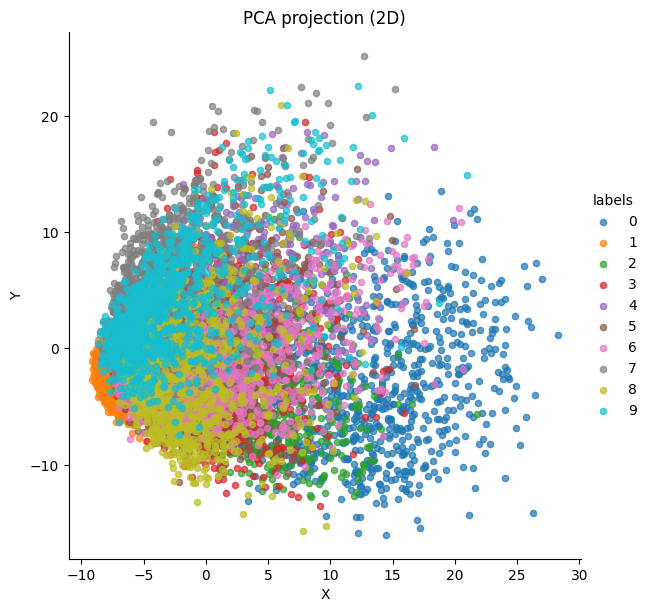

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.006s...
[t-SNE] Computed neighbors for 10000 samples in 2.218s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 3.900588
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.057762
[t-SNE] KL divergence after 1000 iterations: 1.645627


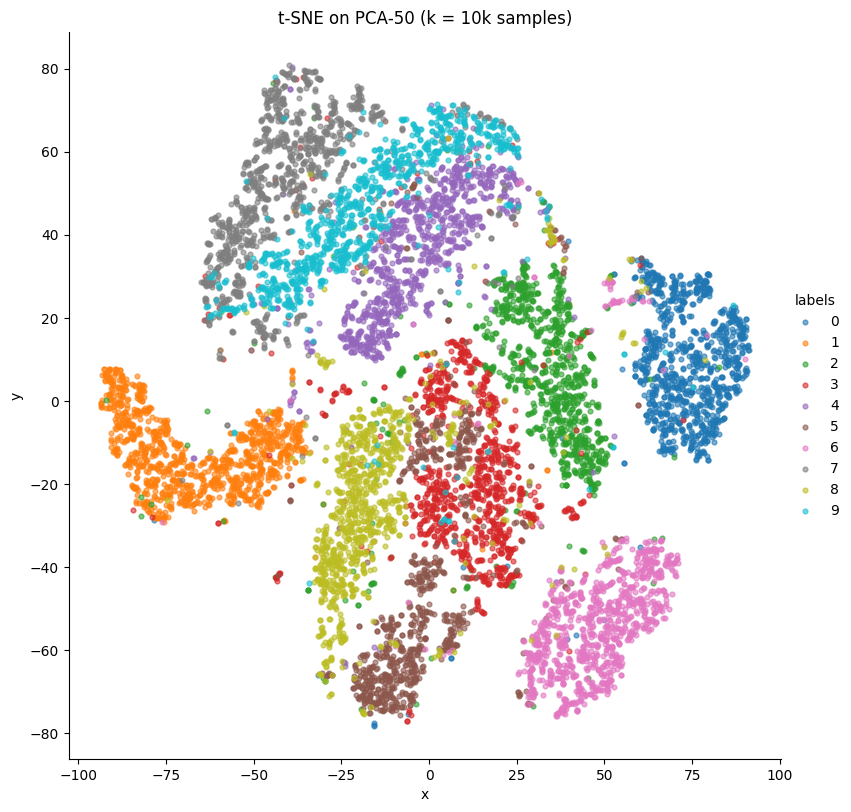

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# 1. Clean up your CSV to a normalized version
def fix_mnist_csv(path, outpath=None):
    df = pd.read_csv(path)
    # Drop any auto-generated “Unnamed” index column from Excel / pandas
    if 'Unnamed: 0' in df.columns:
        df = df.drop('Unnamed: 0', axis=1)
    # Normalize column names
    df.columns = [c.strip().lower() for c in df.columns]
    assert 'label' in df.columns

    pix_cols = [c for c in df.columns if c.startswith('pixel')]
    if len(pix_cols) != 784:
        raise ValueError(f'Found {len(pix_cols)} pixel columns—need exactly 784')

    # Reorder so: [label, pixel0, pixel1, ..., pixel783]
    pix_cols = sorted(pix_cols, key=lambda s: int(s.replace('pixel', '')))
    df = df[['label'] + pix_cols]

    df['label'] = df['label'].astype('int8')
    # Cast pixels to uint8
    df[pix_cols] = df[pix_cols].astype('uint8')

    outpath = outpath or f"{path.rstrip('.csv')}_fixed.csv"
    df.to_csv(outpath, index=False)
    return df

# Example:
df = fix_mnist_csv('train_784.csv')
print("Cleaned train set:", df.shape)  # should be (≈42000, 785)

# df = fix_mnist_csv('train_784.csv', outpath='train_fixed.csv')

# 2. Subset & scale
N = 10000
X = df.drop('label', axis=1).iloc[:N]
y = df['label'].iloc[:N]
X_scaled = StandardScaler().fit_transform(X)

# 3. PCA to 50 dims
pca = PCA(n_components=50, random_state=42)
X_pca50 = pca.fit_transform(X_scaled)

# Plot PCA in 2 dims
pca2 = PCA(n_components=2, random_state=42)
X_pca2 = pca2.fit_transform(X_scaled)
pca_df = pd.DataFrame({'X': X_pca2[:,0], 'Y': X_pca2[:,1], 'labels': y})
grid = sns.FacetGrid(pca_df, hue='labels', height=6, aspect=1)
grid.map(plt.scatter, 'X', 'Y', alpha=0.7, s=20).add_legend()
plt.title('PCA projection (2D)')
plt.show()

# 4. t-SNE on PCA-50
tsne = TSNE(
    n_components=2,
    init='pca',
    perplexity=30,
    learning_rate='auto',
    n_iter=1000,
    random_state=42,
    verbose=1
)
X_tsne = tsne.fit_transform(X_pca50)
tsne_df = pd.DataFrame({'x': X_tsne[:,0], 'y': X_tsne[:,1], 'labels': y})
grid = sns.FacetGrid(tsne_df, hue='labels', height=8, aspect=1)
grid.map_dataframe(plt.scatter, 'x', 'y', alpha=0.6, s=12).add_legend()
plt.title('t‑SNE on PCA‑50 (k = 10k samples)')
plt.show()